### Mike's Exploration of the ADH data...

This builds off of Spencer's replication. It cuts the data in a way that we can plot and understand what is going on...

In [41]:
from  IPython.display  import display, Image # Displays things nicely
import pandas as pd
from pandas_datareader import data, wb # This will import the data reader
import weightedcalcs as wc
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

#fig_path = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\tradeexposure\\figures"
# This is if I want to output the figure

---

## Aggregate Facts

This section will focus on essentially three issues:

- **Expansion of Chinese Trade** and what we show is that essentially **all** of US trade growth since the 1990s is from the expansion of Chinese imports.


- **Fall in Real Interest Rates** Around the time the Chinese trade expanded, real interest rates fell quite dramatically. This is related to Bernanke's "Global Savings Glut" hypothesis. Expositied [here](https://www.federalreserve.gov/boarddocs/speeches/2005/200503102/)


- **Expansion of the Trade Deficit** during this time period. Need to explore.

In [3]:
codes = ["GDP", "IMPGS", "EXPGS", "IMPCH", "GS1", "CPILFESL"] 
# nomial gdp, imports, imports from china, constant maturity 1 year rate, cip (no energy or food)

fred = data.DataReader(codes,"fred",1990)  # Then for fred, you hand it the codes
                                            # Tell it you want to ask from FRED
                                            # then tell it the start date

In [4]:
display(fred.head(10))
#fred.dropna(inplace = True)

,GDP,IMPGS,EXPGS,IMPCH,GS1,CPILFESL
DATE,,,,,,
1990-01-01,5890.835,626.767,538.235,1186.1,7.92,132.1
1990-02-01,NaN,NaN,NaN,993.8,8.11,132.7
1990-03-01,NaN,NaN,NaN,931.0,8.35,133.5
1990-04-01,5974.665,614.759,545.926,996.4,8.40,134.0
1990-05-01,NaN,NaN,NaN,1173.5,8.32,134.4
1990-06-01,NaN,NaN,NaN,1317.2,8.10,135.1
1990-07-01,6029.504,630.102,555.149,1492.5,7.94,135.8
1990-08-01,NaN,NaN,NaN,1568.6,7.78,136.6
1990-09-01,NaN,NaN,NaN,1432.1,7.76,137.1


### Fact \#1:  Growth in Chines Imports Accounts for Aggregate Import Growth

First we need to get things to quarterly frequency with the china stuff...

In [5]:
china_imports = pd.DataFrame(fred["IMPCH"].resample("Q", convention= 'end').sum())

china_imports.index = china_imports.index + pd.DateOffset(days=1)

china_imports.head()

china_imports.rename(columns = {"IMPCH": "ch_imports"}, inplace = True)

trade = fred.merge(china_imports, how = "outer", left_index = True, right_index = True)

trade = trade.resample("Y", convention= 'end').sum()

trade["imports_gdp"] =  100* (trade.IMPGS / trade.GDP )

trade["ch_imports"] = 0.01*trade["ch_imports"] 

trade["frac_china"] = 100.*trade["ch_imports"] / trade["IMPGS"]

trade["china_share"] = 100.*trade["ch_imports"] / trade["GDP"]

In [6]:
trade.loc["2018-12-31"]

trade.drop(pd.to_datetime("2018-12-31"), inplace = True)

trade.head()

,GDP,IMPGS,EXPGS,IMPCH,GS1,CPILFESL,ch_imports,imports_gdp,frac_china,china_share
DATE,,,,,,,,,,
1990-12-31,23918.336,2518.910,2207.496,15237.4,94.59,1625.5,110.912,10.531293,4.403174,0.463711
1991-12-31,24696.200,2494.177,2379.722,18969.2,70.30,1705.4,173.282,10.099436,6.947462,0.701655
1992-12-31,26157.198,2671.163,2532.208,25727.5,46.67,1767.8,244.233,10.211962,9.143321,0.933712
1993-12-31,27514.842,2879.891,2619.194,31539.9,41.21,1826.4,301.245,10.466682,10.460292,1.094845
1994-12-31,29235.022,3253.697,2883.751,38786.8,63.72,1878.0,368.316,11.129449,11.319923,1.259845


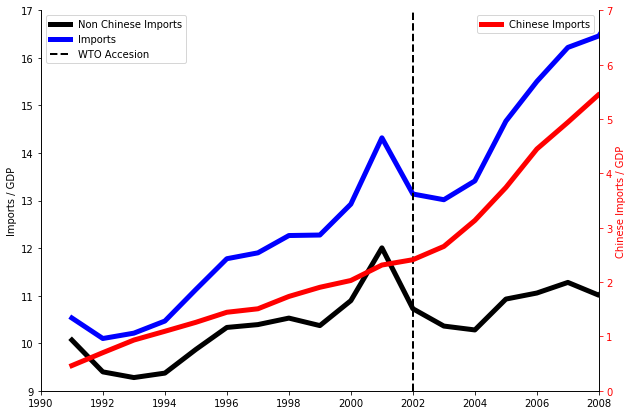

In [7]:
fig, ax = plt.subplots(figsize = (10,7))


ax.plot(trade["imports_gdp"]-trade["china_share"], color = "black",
        linewidth = 5, label = "Non Chinese Imports")

ax.plot(trade["imports_gdp"], color = "blue",
        linewidth = 5, label = "Imports")

ax1 = ax.twinx()

ax1.plot(trade["china_share"], color = "red", lw = 5,
        label = "Chinese Imports")

ax1.set_ylabel('Chinese Imports / GDP', color='r')
ax1.tick_params('y', colors='r')

ax.spines["top"].set_visible(False)
ax1.spines["top"].set_visible(False)


ax.set_ylabel("Imports / GDP") 

ax.set_xlim("1990-01-01", "2008-01-01")

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=2)     # thickness of the line

ax.set_ylim(9,17)
ax1.set_ylim(0,7)

ax.legend()
ax1.legend()

plt.legend()

plt.show()

### Fact \#2 400 basis point fall in real Interest rates leading into China Expansion

In [8]:
irates = pd.DataFrame(fred["GS1"].resample("Q", convention= 'end').mean())

irates.index = irates.index + pd.DateOffset(days=1)

irates.head()

####################3

inflation = pd.DataFrame(fred["CPILFESL"].resample("Q", convention= 'end').mean())

inflation.index = inflation.index + pd.DateOffset(days=1)

irates["real"] = irates["GS1"] - 100*inflation["CPILFESL"].pct_change(4)

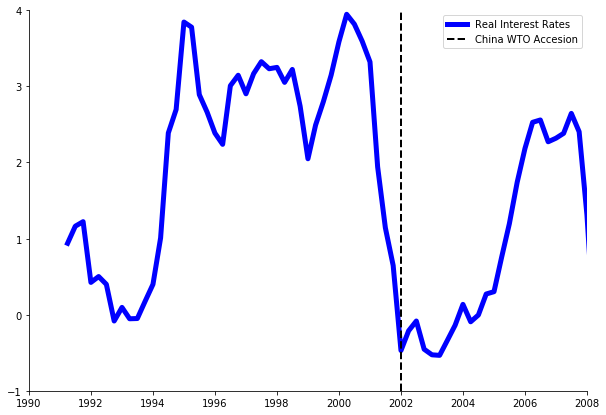

In [9]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(irates.real, color = "blue", lw = 5,
        label = "Real Interest Rates")

ax.set_xlim("1990-01-01", "2008-01-01")
ax.set_ylim(-1, 4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='China WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=2)     # thickness of the line

#ax1 = ax.twinx()

#ax1.plot(trade["china_share"], color = "red", lw = 5,
#        label = "Chinese Imports")

plt.legend()

plt.show()

### Fact #3 Expanding Trade Deficit

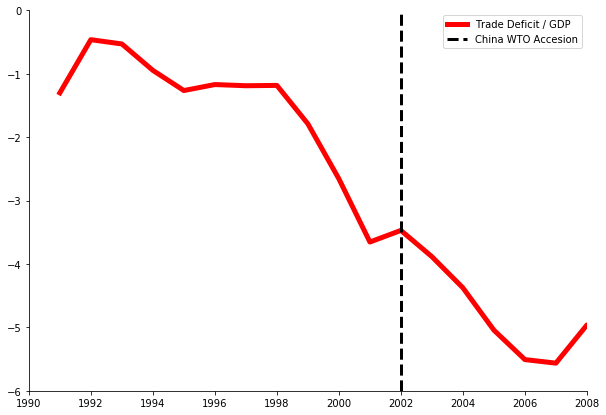

In [10]:
trade["trade_deficit"] = 100*(fred["EXPGS"] - fred["IMPGS"]).resample("Y", convention= 'end').sum()

trade["trade_deficit"] = trade["trade_deficit"]/trade["GDP"]

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(trade.trade_deficit, color = "red", lw = 5,
        label = "Trade Deficit / GDP")

ax.set_xlim("1990-01-01", "2008-01-01")
ax.set_ylim(-6, 0)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='China WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=3)     # thickness of the line

plt.legend()

plt.show()

---

## Micro Facts: ADH Evidence

Below I discuss three key facts that we want our model to replicate from the ADH evidence.

 - **Houshold Income** in Table 9 they have changes in houshold income per adult and then broken down by income type. The closest analog to what is in out model is "wage and salary" income variable. This is the one we will focus on. Its name in the ADH data set is: ``relchg_avg_hhincwage_pc_pw`` The key result is that a one standard deviation increase in the change in IPW results in a -5 percent reduction in wage growth.
 
- **Labor Supply** TBD


- **Migration** TBD

**Details about timing** The timing is as follows. The start of the period is 1991 and then end is 2007. This is then divided into two periods. The first periods is 1991-2000, thus this is a 9 year time period. They convert stuff into a "comparable decadal scale" see Footnote 22. Thus, for values for this period, they multiply them by 10/9.The same issue arises for the second period which is 2000-2007. The values for this are again converted to "decadal scales" so they are multiplied by 10/7. 

The Appendix Table 2, reports the income variable and the decadal adjustments. In the summary statistics for the stuff that we care about, the ADH data is adjusted in this way described above.

### Some Housecleaning of the ADH dataset

We will read in the dataset, create an excel sheet of the variable names, grab the region dummies, and then normalize the IPW measure. This last step is important to map the model to the data.

In [22]:
df = pd.read_stata("workfile_china.dta")
df["const"] = 1

var_names  = pd.DataFrame(df.columns)

var_names.to_excel("var_names.xlsx") # If you want to see what they are (like 200) this 
                                     # this is one way to do it...

regions = list(filter(lambda x: x.startswith("reg"), df.columns))
                                    # Spencer's way to figure out regional dummies.
    
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"] # This grabs the main RHS varibles used in the ADH regressions

calc = wc.Calculator("l_popcount")

df["norm_IPW"] = (df.d_tradeusch_pw - calc.mean(df.set_index("yr").loc[2000], "d_tradeusch_pw")) / (calc.std(df.set_index("yr").loc[2000], "d_tradeusch_pw") )
                 # Take off the mean, divide by the statndard devition. So the value +1 means that value is one standard 
                 # deviation from the mean
        
        
    
display(df.norm_IPW.describe())

count    1444.000000
mean       -0.358674
std         1.283849
min        -1.618437
25%        -1.090114
50%        -0.719801
75%        -0.069941
max        20.108667
Name: norm_IPW, dtype: float64

#### Summary statistics about Trade Exposure, Wages, Labor Supply

#### Trade Explosure

In [12]:


print("Chinese Imports per Worker 1991", 
      round(calc.mean(df.set_index("yr").loc[1990], "l_tradeusch_pw"),2))

print("Chinese Imports per Worker 2000",
      round(calc.mean(df.set_index("yr").loc[2000], "l_tradeusch_pw"),2))


print("Chinese Imports per Worker 1991", 
      round(calc.mean(df.set_index("yr").loc[1990], "l_tradeusch_pw"),2))

print("Chinese Imports per Worker 2000",
      round(calc.mean(df.set_index("yr").loc[2000], "l_tradeusch_pw")/ 
            calc.std(df.set_index("yr").loc[2000], "l_tradeusch_pw")))

print("Chinese Imports per Worker 2000",
      round(calc.mean(df.set_index("yr").loc[2000], "d_tradeusch_pw")/ 
            calc.std(df.set_index("yr").loc[2000], "d_tradeusch_pw")))


df.d_netimpusch_pw.describe()

Chinese Imports per Worker 1991 0.29
Chinese Imports per Worker 2000 1.08
Chinese Imports per Worker 1991 0.29
Chinese Imports per Worker 2000 1.0
Chinese Imports per Worker 2000 1.0


count    1444.000000
mean        1.623339
std         2.514064
min        -2.856775
25%         0.278264
50%         0.901570
75%         2.093192
max        42.226597
Name: d_netimpusch_pw, dtype: float64

So these numbers match up exactly with Appendix, Table 2. The one issue to be mindful of is the year with which the workers are being divided by. In Appendix, Table 2 there are different set of numbers reported depending upon what is picked. 

#### Wages

In [4]:

print("Average Household Wage and Salary, per adult, 1990",
      round(calc.mean(df.set_index("yr").loc[1990], "l_avg_hhincwage_pc_pw"),2))

print("Average Household Wage and Salary, per adult, 2000",
      round(calc.mean(df.set_index("yr").loc[2000], "l_avg_hhincwage_pc_pw"),2),"\n")

print("Average Change in Wages 2007-2000",
      round(calc.median(df.set_index("yr").loc[2000], "relchg_avg_hhincwage_pc_pw"),2))

print("Decadal Adjustment from ADH Numbers", round(100*(10/7)*(28872 - 27655) /27655,2))

Average Household Wage and Salary, per adult, 1990 23495.65
Average Household Wage and Salary, per adult, 2000 27654.94 

Average Change in Wages 2007-2000 6.05
Decadal Adjustment from ADH Numbers 6.29


Again, these match up. Moreover, the latter line provides a benchmark comparison to try and figure out the units. The first line simply reports the average change. The latter takes the averages from ADH, grosses them up to make them decadal equivalents. Then takes the change. Note that they are close suggesting that the pct change reported in the ADH dataset are the decadal equivalents.

In [6]:
print("Average Household Wage and Salary, per adult, 1990",
      round(calc.std(df.set_index("yr").loc[1990], "relchg_avg_hhincwage_pc_pw"),2))

print("Average Household Wage and Salary, per adult, 2000",
      round(calc.std(df.set_index("yr").loc[2000], "relchg_avg_hhincwage_pc_pw"),2),"\n")

Average Household Wage and Salary, per adult, 1990 6.51
Average Household Wage and Salary, per adult, 2000 8.83 



### Labor Supply

In [15]:

print("Share not in labor force, 1990",
      round(calc.mean(df.set_index("yr").loc[1990], "l_sh_nilf"),2))

print("Share not in labor force, 2000",
      round(calc.mean(df.set_index("yr").loc[2000], "l_sh_nilf"),2),"\n")

print("Average Change in Wages 2007-2000",
      round(calc.mean(df.set_index("yr").loc[2000], "d_sh_nilf"),2))


Share not in labor force, 1990 24.76
Share not in labor force, 2000 26.05 

Average Change in Wages 2007-2000 -1.82


---
### Household Wage Income Results...

I first want to plot this and cut it by the time period. ADH main results stack two time periods 90s and 2000s. The 2000s correspond with the big rise in Chinese trade; the 1990s is far less dramatic. 

#### The plot test

Lets simply plot the change in IPW vs. the percent change in household "wage and salary" income per adult.

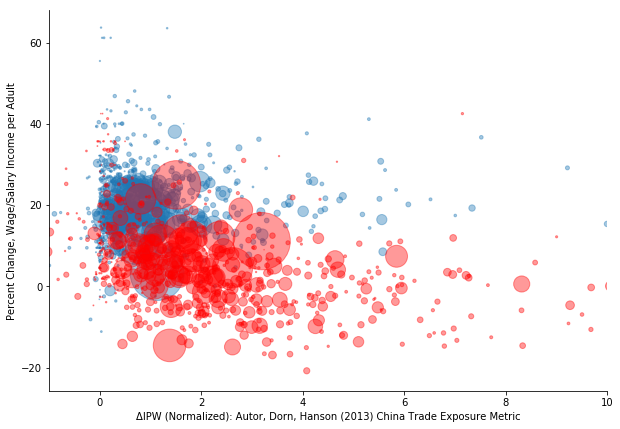

In [23]:
fig, ax = plt.subplots(figsize = (10,7))

year = "1990"

#df["norm_IPW"]

ax.scatter(df.set_index("yr").loc[int(year)].d_netimpusch_pw, #X variables
           df.set_index("yr").loc[int(year)].relchg_avg_hhincwage_pc_pw,     # y variables 
            s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40) 

year = "2000"

ax.scatter(df.set_index("yr").loc[int(year)].d_netimpusch_pw, #X variables
           df.set_index("yr").loc[int(year)].relchg_avg_hhincwage_pc_pw,     # y variables 
           s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40, color = "red") 

ax.set_ylabel("Percent Change, Wage/Salary Income per Adult") 
ax.set_xlabel("ΔIPW (Normalized): Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-1,10)
#ax.set_ylim(-20,45)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data_wage_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

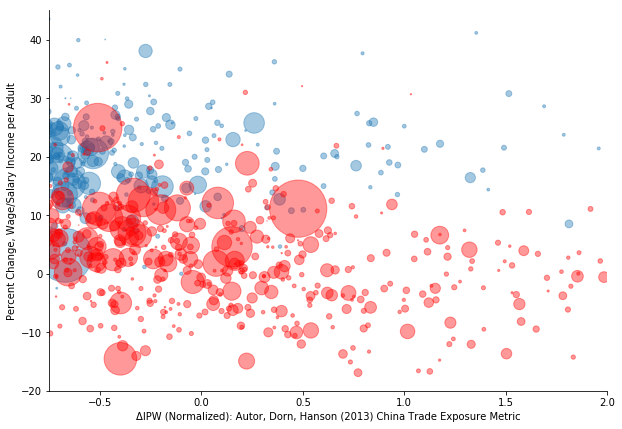

In [24]:
fig, ax = plt.subplots(figsize = (10,7))

year = "1990"

#df["norm_IPW"]

ax.scatter(df.set_index("yr").loc[int(year)].norm_IPW, #X variables
           df.set_index("yr").loc[int(year)].relchg_avg_hhincwage_pc_pw,     # y variables 
            s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40) 

year = "2000"

ax.scatter(df.set_index("yr").loc[int(year)].norm_IPW, #X variables
           df.set_index("yr").loc[int(year)].relchg_avg_hhincwage_pc_pw,     # y variables 
           s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40, color = "red") 

ax.set_ylabel("Percent Change, Wage/Salary Income per Adult") 
ax.set_xlabel("ΔIPW (Normalized): Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-0.75,2.00)
ax.set_ylim(-20,45)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data_wage_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

This is quite interesting. What do I see:

- First you see how there is far more variation in trade exposure for the 2000s (red) periods vs. the 90s (blue). China came in and **fundamentally altered a commute zones exposure to trade by large amounts** 


- If you eye-ball this enough, for the 90s, **there is essentially zero correlation between income growth and trade exposure during this time period.** If anything, it is slightly positive.


- If you look at the 2000s (red), two things are going on. First, wage growth is lower overall. Second, there is **MAYBE** a "hockey stick" pattern between wage growth and trade exposure.


- Finally, a better characterization of the data is this (i) in 1990's, there is no relationship and (ii) in the 2000's the average growth rate of wages fell, but variance when up a bunch (and there is no relationship wither within the 2000's). But what we have is two clusters: the 1990s with low exposure, high wages and then another cluster with high exposure, low wages. Then you get a negative slope? 

#### Now this is the specification that will replicate Table 9 in ADH

In [26]:
###############################################################################
# Then this does the specification that will replicate ADH...
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

rhs_var.append("t2")

reg_df = df
    
res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.d_tradeusch_pw, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                              IV-2SLS Estimation Summary                              
Dep. Variable:     relchg_avg_hhincwage_pc_pw   R-squared:                      0.4278
Estimator:                            IV-2SLS   Adj. R-squared:                 0.4214
No. Observations:                        1444   F-statistic:                    735.75
Date:                        Wed, May 23 2018   P-value (F-stat)                0.0000
Time:                                14:56:36   Distribution:                 chi2(16)
Cov. Estimator:                     clustered                                         
                                                                                      
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 60.679     8.9966     6.

**So the results ``-2.1416 (0.5851)`` exactly matches up with the ADH coeffecient estimate. Now below I will do it with a normalization.**

In [32]:
res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.norm_IPW, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                              IV-2SLS Estimation Summary                              
Dep. Variable:     relchg_avg_hhincwage_pc_pw   R-squared:                      0.4765
Estimator:                            IV-2SLS   Adj. R-squared:                 0.4706
No. Observations:                        1444   F-statistic:                    309.68
Date:                        Wed, May 23 2018   P-value (F-stat)                0.0000
Time:                                15:07:40   Distribution:                 chi2(16)
Cov. Estimator:                     clustered                                         
                                                                                      
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 32.522     10.664     3.

Which says that a **one standard deviation increase in the change in IPW** results in a **-5 percent** reduction in wage growth.

---

---
### Labor Supply Results...

Same deal as above. First plot it, then replicate ADH, then our normalized measure. 

#### The plot test

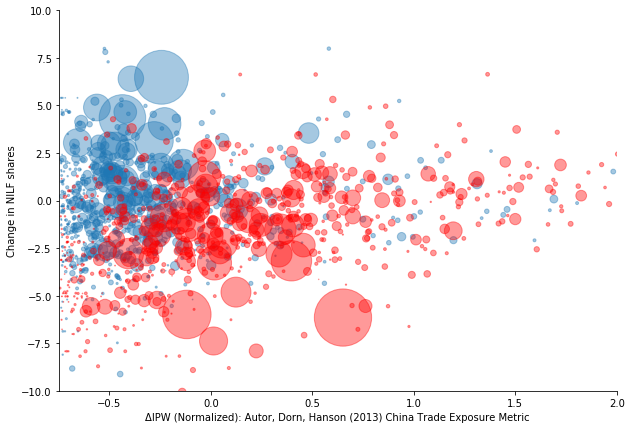

In [19]:
fig, ax = plt.subplots(figsize = (10,7))

year = "1990"

#df["norm_IPW"]

ax.scatter(df.set_index("yr").loc[int(year)].norm_IPW, #X variables
           df.set_index("yr").loc[int(year)].d_sh_nilf,     # y variables 
            s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40) 

year = "2000"

ax.scatter(df.set_index("yr").loc[int(year)].norm_IPW, #X variables
           df.set_index("yr").loc[int(year)].d_sh_nilf,     # y variables 
           s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40, color = "red") 

ax.set_ylabel("Change in NILF shares") 
ax.set_xlabel("ΔIPW (Normalized): Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-0.75,2.00)
ax.set_ylim(-10,10)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data_wage_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

Same story as above, not much relationship for 1990s. Then a clear positive relationship emerges for the 2000s period. This means that CMZ's with higher trade exposure had increases in the share of the working age population not in the labor force.

In [22]:
###############################################################################
# Then this does the specification that will replicate ADH...
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

#rhs_var.append("t2")

reg_df = df
    
res_first = IV2SLS(reg_df.d_sh_nilf, 
                   reg_df[["const"]+ rhs_var + regions + ["d_tradeusch_pw"]],
                   None, 
                   None,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                            OLS Estimation Summary                            
Dep. Variable:              d_sh_nilf   R-squared:                      0.3202
Estimator:                        OLS   Adj. R-squared:                 0.3130
No. Observations:                1444   F-statistic:                    365.58
Date:                Mon, May 21 2018   P-value (F-stat)                0.0000
Time:                        14:38:52   Distribution:                 chi2(15)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                -8.4748     3.3985    -2.4937     0.0126     -15.136     -1.8139
l_shind_manuf_cbp     0.

In [33]:
res_first = IV2SLS(reg_df.d_sh_nilf, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.norm_IPW, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])


print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              d_sh_nilf   R-squared:                      0.3860
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3792
No. Observations:                1444   F-statistic:                    462.05
Date:                Wed, May 23 2018   P-value (F-stat)                0.0000
Time:                        15:43:46   Distribution:                 chi2(16)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                -15.295     3.5911    -4.2592     0.0000     -22.333     -8.2566
l_shind_manuf_cbp    -0.

**Which says that a increase in one standard deviation of trade exposure results in a 1.42 percentage point increase in the share of not in the labor force.** 

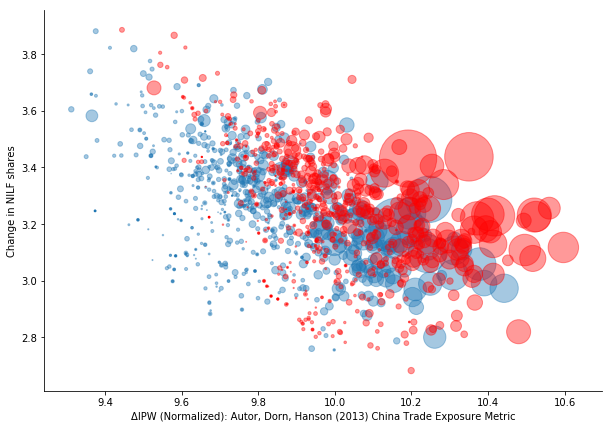

Average Change in Wages 2007-2000 75.24


In [53]:
fig, ax = plt.subplots(figsize = (10,7))

year = "1990"

#df["norm_IPW"]

ax.scatter(np.log(df.set_index("yr").loc[int(year)].l_avg_hhincwage_pc_pw), #X variables
           np.log(df.set_index("yr").loc[int(year)].l_sh_nilf),     # y variables 
            s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40) 

year = "2000"

ax.scatter(np.log(df.set_index("yr").loc[int(year)].l_avg_hhincwage_pc_pw), #X variables
           np.log(df.set_index("yr").loc[int(year)].l_sh_nilf),     # y variables 
           s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40, color = "red") 

ax.set_ylabel("Change in NILF shares") 
ax.set_xlabel("ΔIPW (Normalized): Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

#ax.set_xlim(-0.75,2.00)
#ax.set_ylim(-10,10)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data_wage_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

print("Average Change in Wages 2007-2000",
      100-round(calc.mean(df.set_index("yr").loc[1990], "l_sh_nilf"),2))